In this file, we:

- Aggregate the extracted project meta-data from the website
- Separate between single- and multiple-phase projects
- For both groups perform cluster analysis to group similar reports

**Result: CSV file with aggregated project meta-data and cluster label**

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import fitz  # PyMuPDF
from PIL import Image
import matplotlib.pyplot as plt
import pickle

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

All project_data csv contains similar projects multiple times for different phases. First, we aggregate all projects so that we get one entry for one project. While doing that we create a new variable: multiple_phases. This is a dummy variable illustrating which project has multiple phases. This is important because these reports have different formats.

In [2]:
project_data = pd.read_csv("project_data.csv")

agg_data = project_data.groupby('pdf').agg(
    project_name=('project_name', 'first'),
    multiple_phases=('project_name', 'nunique'),
    number_countries=('country', 'nunique'),
    eval_year=('year', 'first'),
    number_sectors=('sector', 'nunique'),
    number_subsectors=('subsector', 'nunique'),
    mean_investment=('investment', 'mean'),
    number_funding_source=('fund_source', 'nunique'),
    number_carrier_type=('carrier_type', 'nunique'),
    overall_rating=('overall_rating', 'last'),
    relevance=('relevance', 'mean'),
    coherence=('coherence', 'mean'),
    effectivity=('effectivity', 'mean'),
    efficiency=('efficiency', 'mean'),
    impact=('impact', 'mean'),
    sustainability=('sustainability', 'mean'),
    url=('url', 'first')
).reset_index()

agg_data["multiple_phases"] = agg_data["multiple_phases"].apply(lambda x: 0 if x == 1 else 1)

agg_data.head()

,pdf,project_name,multiple_phases,number_countries,eval_year,number_sectors,number_subsectors,mean_investment,number_funding_source,number_carrier_type,overall_rating,relevance,coherence,effectivity,efficiency,impact,sustainability,url
0,%C3%84gypten_Bew%C3%A4sserung_2020_D.pdf,Verbesserung des Bewässerungssystems I,1,1,2020,1,1,96800000.0,1,1,2,2.0,NaN,2.0,2.0,4.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84gypten_Bew%C3%A4sserung_2020_D.pdf
1,%C3%84gypten_Qena_2022_D.pdf,Kommunale Wasserver- und Abwasserentsorgung Qena,0,1,2022,1,1,12670000.0,1,1,3,2.0,3.0,3.0,2.0,3.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84gypten_Qena_2022_D.pdf
2,%C3%84gypten_Umwelt_2022_D.pdf,Förderung von Umweltschutzmaßnahmen der privaten Industrie II,0,1,2022,1,1,25780000.0,1,1,3,3.0,2.0,3.0,3.0,4.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84gypten_Umwelt_2022_D.pdf
3,%C3%84thiopien_Gavi_2022_D.pdf,Impfprogrammförderung in Äthiopien in Zusammenarbeit mit der GAVI-Alliance,0,1,2022,1,1,10000000.0,1,1,3,2.0,3.0,3.0,3.0,3.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84thiopien_Gavi_2022_D.pdf
4,Afrika_ICF_2015_D.pdf,Investment <span lang='en'>Climate Facility for Africa (ICF)</span>,1,1,2015,1,1,72500000.0,1,1,3,2.0,NaN,3.0,3.0,3.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Afrika_ICF_2015_D.pdf


We delete project entries with missing pdf files from agg_data.

In [3]:
# Delete missing pdfs from data frame
agg_data = agg_data.drop([239, 426, 501, 716])

In [4]:
# Check which pdfs are not in the directory
current_directory = os.getcwd()
folder_path = os.path.join(current_directory, 'pdf_reports')

pdf_files_in_folder = set(f for f in os.listdir(folder_path) if f.endswith('.pdf'))

pdf_files_in_df = set(agg_data["pdf"])

pdfs_not_in_folder = pdf_files_in_df - pdf_files_in_folder

# Print the result
if pdfs_not_in_folder:
    print("PDFs not found in the folder:")
    for pdf in pdfs_not_in_folder:
        print(pdf)
else:
    print("All PDFs are present in the folder.")

All PDFs are present in the folder.


In [5]:
# Checking the shape of agg_data for later checks
agg_data.shape

(739, 18)

Next, we separate all one-phase projects from multiple phase projects.

In [6]:
df_one_phase = agg_data[agg_data["multiple_phases"] == 0]
df_multiple_phases = agg_data[agg_data["multiple_phases"] == 1]

For both created dataframes df_one_phase and df_multiple_phases we run a cluster analysis, to group pdf files with the same format. First we create several functions for it.

In [7]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Extract the first page of the PDFs and save as image
def extract_first_page_image(pdf_path):
    doc = fitz.open(pdf_path)
    page = doc.load_page(0)
    pix = page.get_pixmap()
    image_path = pdf_path.replace('.pdf', '.png')
    pix.save(image_path)
    return image_path

# Load the first page image and preprocess it
def load_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        return img
    except Exception as e:
        print(f"Error loading the image: {image_path}, Error: {e}")
        return None

# Extract features from the image using the CNN
def extract_features(image_path):
    img = load_image(image_path)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")
    features = model.predict(img)
    return features.flatten()

# Extract features for all PDFs
def extract_features_for_all_pdfs(df, pdf_folder):
    features_list = []
    for pdf_file in df['pdf']:
        pdf_path = os.path.join(pdf_folder, pdf_file)
        image_path = extract_first_page_image(pdf_path)
        features = extract_features(image_path)
        features_list.append(features)
        os.remove(image_path)  # Clean up the image file after extracting features
    return np.array(features_list)

# Save the extracted features to a file
def save_features(features, filename):
    with open(filename, 'wb') as f:
        pickle.dump(features, f)

# Load the extracted features from a file
def load_features(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Cluster the PDFs based on the extracted features
def cluster_pdfs(df, features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = kmeans.fit_predict(features)
    df['cluster'] = cluster_labels
    return df

#### Cluster Analysis for single-phase projects:

In [8]:
current_directory = os.getcwd()
pdf_folder = os.path.join(current_directory, 'pdf_reports')

# Extract features and save them
features1 = extract_features_for_all_pdfs(df_one_phase, pdf_folder)
save_features(features1, 'features.pkl1')

# Load features and perform clustering with different numbers of clusters
features1 = load_features('features.pkl1')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━

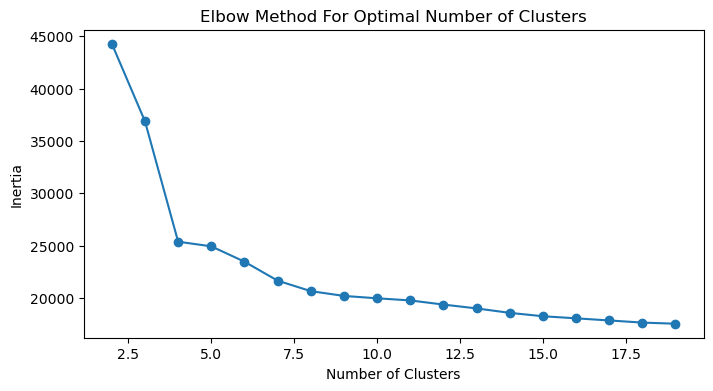

In [9]:
# We estimate the optimal number of clusters using the Elbow method
cluster_numbers = range(2, 20)
inertia1 = []

for k in cluster_numbers:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(features1)
    inertia1.append(kmeans.inertia_)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(cluster_numbers, inertia1, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

We choose 8 as the number of clusters and creating the final dataframe.

In [10]:
df_one_phase_clustered = cluster_pdfs(df_one_phase.copy(), features1, n_clusters=8)
df_one_phase_clustered.head()

,pdf,project_name,multiple_phases,number_countries,eval_year,number_sectors,number_subsectors,mean_investment,number_funding_source,number_carrier_type,overall_rating,relevance,coherence,effectivity,efficiency,impact,sustainability,url,cluster
1,%C3%84gypten_Qena_2022_D.pdf,Kommunale Wasserver- und Abwasserentsorgung Qena,0,1,2022,1,1,12670000.0,1,1,3,2.0,3.0,3.0,2.0,3.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84gypten_Qena_2022_D.pdf,3
2,%C3%84gypten_Umwelt_2022_D.pdf,Förderung von Umweltschutzmaßnahmen der privaten Industrie II,0,1,2022,1,1,25780000.0,1,1,3,3.0,2.0,3.0,3.0,4.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84gypten_Umwelt_2022_D.pdf,3
3,%C3%84thiopien_Gavi_2022_D.pdf,Impfprogrammförderung in Äthiopien in Zusammenarbeit mit der GAVI-Alliance,0,1,2022,1,1,10000000.0,1,1,3,2.0,3.0,3.0,3.0,3.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84thiopien_Gavi_2022_D.pdf,3
5,Afrika_TCX_2012_D.pdf,Lokalwährungsfonds TCX,0,1,2012,1,1,90000000.0,1,1,2,2.0,NaN,1.0,2.0,1.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Afrika_TCX_2012_D.pdf,7
7,Albanien_Elbasan_2011.pdf,Wirtschaftsförderung durch Ausbau kommunaler Infrastruktur Elbasan,0,1,2011,1,1,10600000.0,1,1,4,3.0,NaN,4.0,4.0,4.0,3.0,https://www.kfw-entwicklungsbank.de/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Albanien_Elbasan_2011.pdf,2


#### Cluster Analysis for multiple-phase projects:

In [11]:
current_directory = os.getcwd()
pdf_folder = os.path.join(current_directory, 'pdf_reports')

# Extract features and save them
features2 = extract_features_for_all_pdfs(df_multiple_phases, pdf_folder)
save_features(features2, 'features.pkl2')

# Load features and perform clustering with different numbers of clusters
features2 = load_features('features.pkl2')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


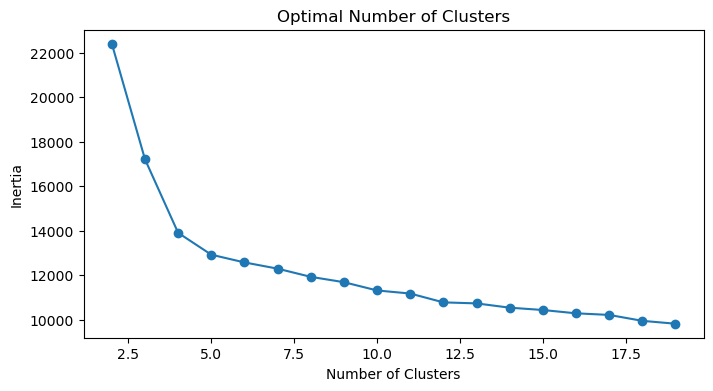

In [12]:
cluster_numbers = range(2, 20)
inertia2 = []

for k in cluster_numbers:
    kmeans = KMeans(n_clusters=k, random_state=123).fit(features2)
    inertia2.append(kmeans.inertia_)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(cluster_numbers, inertia2, marker='o')
plt.title('Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

We choose 5 clusters:

In [13]:
df_multiple_phases_clustered = cluster_pdfs(df_multiple_phases.copy(), features2, n_clusters=5)
df_multiple_phases_clustered.head()

,pdf,project_name,multiple_phases,number_countries,eval_year,number_sectors,number_subsectors,mean_investment,number_funding_source,number_carrier_type,overall_rating,relevance,coherence,effectivity,efficiency,impact,sustainability,url,cluster
0,%C3%84gypten_Bew%C3%A4sserung_2020_D.pdf,Verbesserung des Bewässerungssystems I,1,1,2020,1,1,96800000.0,1,1,2,2.0,NaN,2.0,2.0,4.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84gypten_Bew%C3%A4sserung_2020_D.pdf,1
4,Afrika_ICF_2015_D.pdf,Investment <span lang='en'>Climate Facility for Africa (ICF)</span>,1,1,2015,1,1,72500000.0,1,1,3,2.0,NaN,3.0,3.0,3.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Afrika_ICF_2015_D.pdf,1
6,Albanien_AE-Korca-III_2016_D.pdf,Abwasserentsorgung Korca III,1,1,2016,1,1,25400000.0,1,1,1,1.0,NaN,1.0,1.0,2.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Albanien_AE-Korca-III_2016_D.pdf,1
9,Albanien_Infrastruktur_2022_D.pdf,Kommunale Infrastruktur II (Zinssubventioniertes Darlehen),1,1,2022,1,1,2245000.0,1,1,3,2.0,2.0,3.0,3.0,3.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Albanien_Infrastruktur_2022_D.pdf,3
10,Albanien_Kruja_2009.pdf,Wasserver- und -entsorgung Kruja,1,1,2009,1,1,4210000.0,1,1,4,3.0,NaN,3.0,4.0,5.0,4.0,https://www.kfw-entwicklungsbank.de/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Albanien_Kruja_2009.pdf,0


#### agg_data_clustered
Next, we vertically append both dataframes to get one dataframe for all projects. Before that, we must change cluster labels for one of both dataframes.

In [14]:
# We add the number of clusters of df_sinle_phase_clustered to get different labels
df_multiple_phases_clustered["cluster"] = df_multiple_phases_clustered["cluster"] + 8
df_multiple_phases_clustered.head(3)

,pdf,project_name,multiple_phases,number_countries,eval_year,number_sectors,number_subsectors,mean_investment,number_funding_source,number_carrier_type,overall_rating,relevance,coherence,effectivity,efficiency,impact,sustainability,url,cluster
0,%C3%84gypten_Bew%C3%A4sserung_2020_D.pdf,Verbesserung des Bewässerungssystems I,1,1,2020,1,1,96800000.0,1,1,2,2.0,NaN,2.0,2.0,4.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84gypten_Bew%C3%A4sserung_2020_D.pdf,9
4,Afrika_ICF_2015_D.pdf,Investment <span lang='en'>Climate Facility for Africa (ICF)</span>,1,1,2015,1,1,72500000.0,1,1,3,2.0,NaN,3.0,3.0,3.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Afrika_ICF_2015_D.pdf,9
6,Albanien_AE-Korca-III_2016_D.pdf,Abwasserentsorgung Korca III,1,1,2016,1,1,25400000.0,1,1,1,1.0,NaN,1.0,1.0,2.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Albanien_AE-Korca-III_2016_D.pdf,9


Lastly, we append both dataframes and export the final one as a CSV.

In [15]:
agg_data_clustered = pd.concat([df_one_phase_clustered, df_multiple_phases_clustered], ignore_index=True)
print(agg_data_clustered.shape)
agg_data_clustered.head()

(739, 19)


,pdf,project_name,multiple_phases,number_countries,eval_year,number_sectors,number_subsectors,mean_investment,number_funding_source,number_carrier_type,overall_rating,relevance,coherence,effectivity,efficiency,impact,sustainability,url,cluster
0,%C3%84gypten_Qena_2022_D.pdf,Kommunale Wasserver- und Abwasserentsorgung Qena,0,1,2022,1,1,12670000.0,1,1,3,2.0,3.0,3.0,2.0,3.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84gypten_Qena_2022_D.pdf,3
1,%C3%84gypten_Umwelt_2022_D.pdf,Förderung von Umweltschutzmaßnahmen der privaten Industrie II,0,1,2022,1,1,25780000.0,1,1,3,3.0,2.0,3.0,3.0,4.0,3.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84gypten_Umwelt_2022_D.pdf,3
2,%C3%84thiopien_Gavi_2022_D.pdf,Impfprogrammförderung in Äthiopien in Zusammenarbeit mit der GAVI-Alliance,0,1,2022,1,1,10000000.0,1,1,3,2.0,3.0,3.0,3.0,3.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/%C3%84thiopien_Gavi_2022_D.pdf,3
3,Afrika_TCX_2012_D.pdf,Lokalwährungsfonds TCX,0,1,2012,1,1,90000000.0,1,1,2,2.0,NaN,1.0,2.0,1.0,2.0,https://www.kfw-entwicklungsbank.de/PDF/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Afrika_TCX_2012_D.pdf,7
4,Albanien_Elbasan_2011.pdf,Wirtschaftsförderung durch Ausbau kommunaler Infrastruktur Elbasan,0,1,2011,1,1,10600000.0,1,1,4,3.0,NaN,4.0,4.0,4.0,3.0,https://www.kfw-entwicklungsbank.de/Evaluierung/Ergebnisse-und-Publikationen/PDF-Dokumente-A-D/Albanien_Elbasan_2011.pdf,2


In [16]:
agg_data_clustered.to_csv("agg_data2.csv", index=False)